<a href="https://colab.research.google.com/github/schadmichael/ParsingQuotes/blob/main/backtesting_sp500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3206637558.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.ticker, start=self.start, end=self.end, progress=False)
/tmp/ipython-input-3206637558.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.data = pd.to_numeric(df["Close"].squeeze(), errors='coerce').resample("M").last().dropna()


1153 mois de données téléchargés.


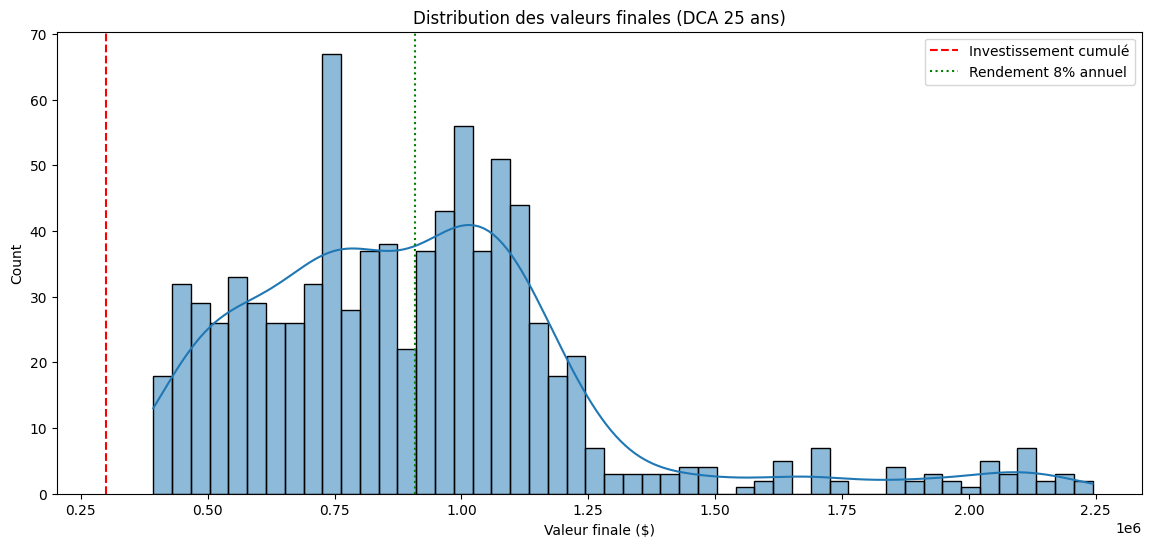

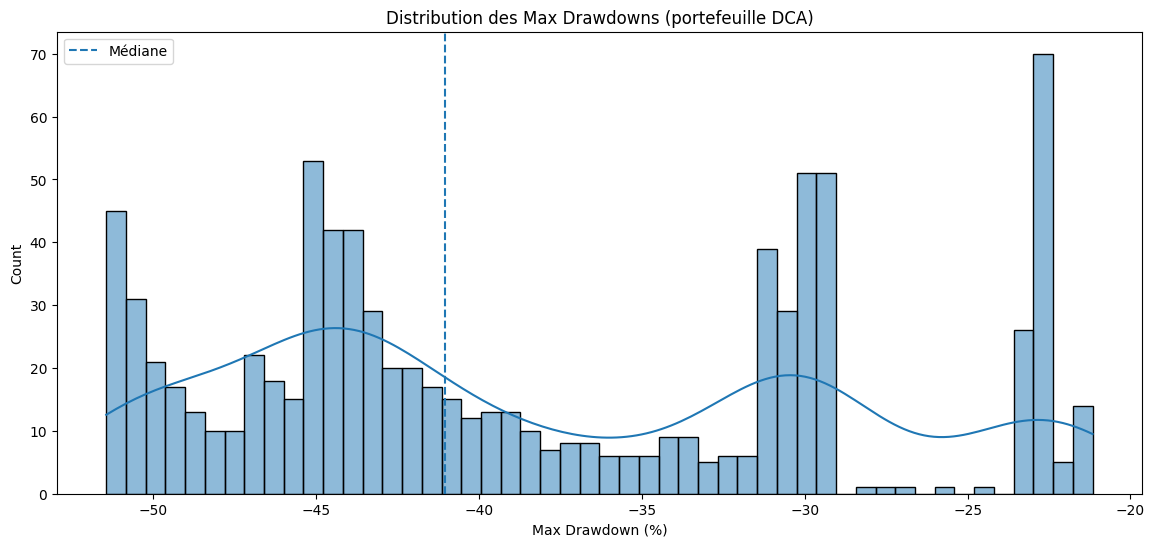

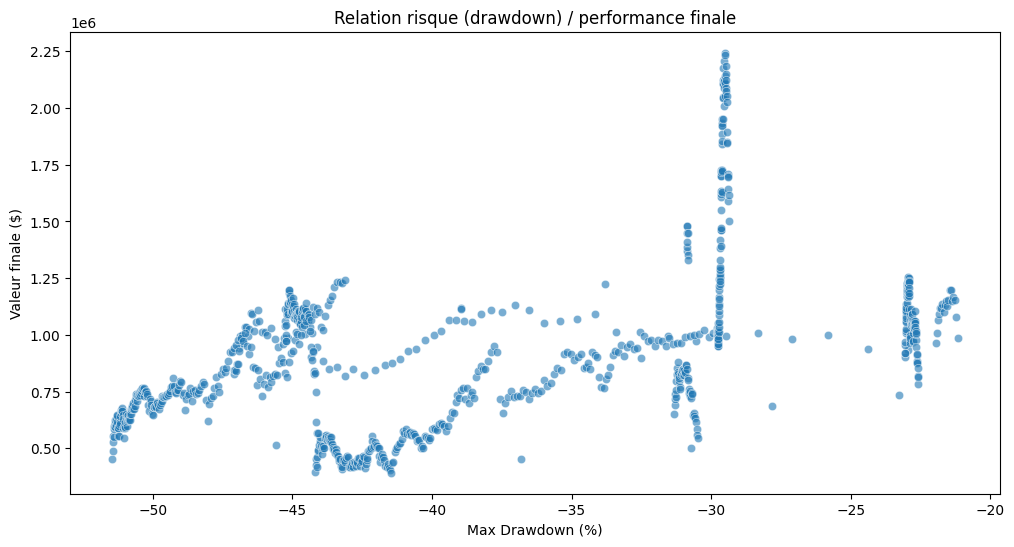

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class DCAEstimator:
    def __init__(self, ticker="^GSPC", start="1930-01-01", end=None, monthly_amount=100):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.monthly_amount = monthly_amount
        self.data = None
        self.results = []

    def download_data(self):
        df = yf.download(self.ticker, start=self.start, end=self.end, progress=False)
        # Ensure the 'Close' column is numeric and a Series before resampling
        self.data = pd.to_numeric(df["Close"].squeeze(), errors='coerce').resample("M").last().dropna()
        print(f"{len(self.data)} mois de données téléchargés.")

    def _compute_max_drawdown(self, portfolio_values):
        running_max = np.maximum.accumulate(portfolio_values)
        drawdowns = (portfolio_values - running_max) / running_max
        return drawdowns.min()

    def simulate_dca(self, window_years=25):
        if self.data is None:
            raise ValueError("Télécharge les données d'abord.")

        months = window_years * 12
        prices = self.data
        self.window_years = window_years # Store window_years for plot_results

        for i in range(len(prices) - months + 1):
            window = prices.iloc[i:i + months]

            shares = 0
            portfolio_values = []

            for price in window:
                shares += self.monthly_amount / price
                portfolio_values.append(shares * price)

            final_value = portfolio_values[-1]
            total_invested = self.monthly_amount * months
            max_dd = self._compute_max_drawdown(np.array(portfolio_values))

            self.results.append({
                "start_date": window.index[0],
                "final_value": final_value,
                "total_invested": total_invested,
                "max_drawdown": max_dd
            })

    def plot_results(self):
        df = pd.DataFrame(self.results)

        # ===============================
        # Distribution valeur finale
        # ===============================
        plt.figure(figsize=(14, 6))
        sns.histplot(df["final_value"], bins=50, kde=True)
        plt.axvline(df["total_invested"].mean(), color="red", linestyle="--",
                    label="Investissement cumulé")

        # Calculate future value with 8% annual return
        monthly_rate = (1 + 0.08)**(1/12) - 1
        num_months = self.window_years * 12
        future_value_8_percent = self.monthly_amount * (((1 + monthly_rate)**num_months - 1) / monthly_rate)
        plt.axvline(future_value_8_percent, color="green", linestyle=":", label="Rendement 8% annuel")

        plt.title(f"Distribution des valeurs finales (DCA {self.window_years} ans)")
        plt.xlabel("Valeur finale ($)")
        plt.legend()
        plt.show()

        # ===============================
        # Distribution max drawdowns
        # ===============================
        plt.figure(figsize=(14, 6))
        sns.histplot(df["max_drawdown"] * 100, bins=50, kde=True)
        plt.title("Distribution des Max Drawdowns (portefeuille DCA)")
        plt.xlabel("Max Drawdown (%)")
        plt.axvline(df["max_drawdown"].median() * 100,
                    linestyle="--", label="Médiane")
        plt.legend()
        plt.show()

        # ===============================
        # Relation drawdown vs performance
        # ===============================
        plt.figure(figsize=(12, 6))
        sns.scatterplot(
            x=df["max_drawdown"] * 100,
            y=df["final_value"],
            alpha=0.6
        )
        plt.xlabel("Max Drawdown (%)")
        plt.ylabel("Valeur finale ($)")
        plt.title("Relation risque (drawdown) / performance finale")
        plt.show()


# ===============================
# ▶️ Exécution
# ===============================

salaire=2200
monthly_amount=salaire*0.15
estimator = DCAEstimator(monthly_amount=1000)
estimator.download_data()
estimator.simulate_dca(window_years=25)
estimator.plot_results()